In [176]:
import pandas as pd
import numpy as np

In [68]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV

In [30]:
import seaborn as sns

In [8]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [119]:
district_df = pd.read_csv("../data/district_case_comps.csv")
crime_df = pd.read_csv("../data/dstrIPC_1.csv")

In [120]:
crime_df["DISTRICT"] = crime_df["DISTRICT"].str.lower()

In [121]:
crime_df.columns

Index(['STATE/UT', 'DISTRICT', 'YEAR', 'MURDER', 'ATTEMPT TO MURDER',
       'CULPABLE HOMICIDE NOT AMOUNTING TO MURDER', 'RAPE', 'CUSTODIAL RAPE',
       'OTHER RAPE', 'KIDNAPPING & ABDUCTION',
       'KIDNAPPING AND ABDUCTION OF WOMEN AND GIRLS',
       'KIDNAPPING AND ABDUCTION OF OTHERS', 'DACOITY',
       'PREPARATION AND ASSEMBLY FOR DACOITY', 'ROBBERY', 'BURGLARY', 'THEFT',
       'AUTO THEFT', 'OTHER THEFT', 'RIOTS', 'CRIMINAL BREACH OF TRUST',
       'CHEATING', 'COUNTERFIETING', 'ARSON', 'HURT/GREVIOUS HURT',
       'DOWRY DEATHS', 'ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY',
       'INSULT TO MODESTY OF WOMEN', 'CRUELTY BY HUSBAND OR HIS RELATIVES',
       'IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES',
       'CAUSING DEATH BY NEGLIGENCE', 'OTHER IPC CRIMES', 'TOTAL IPC CRIMES'],
      dtype='object')

In [122]:
# aggregate crime data for now

In [123]:
crime_df = crime_df[
    (crime_df["DISTRICT"] != "total")&
    (crime_df["YEAR"] > 2010)].groupby(["STATE/UT", "DISTRICT"])[["TOTAL IPC CRIMES","OTHER IPC CRIMES"]].mean().reset_index()

In [124]:
merged_df = district_df.merge(crime_df, left_on="district_name", right_on="DISTRICT", how = "inner")
merged_df

,pc11_state_id,pc11_district_id,state_name,district_name,st_share,sc_share,ptg_share,tot_p,inc_5k_plus_share,disab_share,scav_share,house_type3,ed_prim_share,land_own_share,STATE/UT,DISTRICT,TOTAL IPC CRIMES,OTHER IPC CRIMES
0,1,1,jammu kashmir,kupwara,0.018420,0.000608,0.001132,598707.0,0.273440,0.902448,0.000174,0.001139,0.523096,0.791104,JAMMU & KASHMIR,kupwara,781.5,295.0
1,1,4,jammu kashmir,kargil,0.298980,0.000090,0.011493,110533.0,0.480378,0.900534,0.004285,0.000000,0.543989,0.591850,JAMMU & KASHMIR,kargil,110.5,79.5
2,1,6,jammu kashmir,rajouri,0.128456,0.038889,0.004218,603954.0,0.266523,0.901133,0.000783,0.000326,0.506377,0.947900,JAMMU & KASHMIR,rajouri,1863.0,1340.0
3,1,7,jammu kashmir,kathua,0.033276,0.075045,0.003898,518943.0,0.369915,0.900782,0.010199,0.001487,0.578723,0.668616,JAMMU & KASHMIR,kathua,1212.0,848.0
4,1,10,jammu kashmir,srinagar,0.038159,0.000053,0.000000,16645.0,0.286356,0.900343,0.000000,0.020691,0.468158,0.550060,JAMMU & KASHMIR,srinagar,2685.0,1123.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,33,630,tamil nadu,dharmapuri,0.029023,0.070605,0.010590,210870.0,0.229055,0.900506,0.000070,0.001426,0.444996,0.484355,TAMIL NADU,dharmapuri,3658.0,1706.0
469,33,631,tamil nadu,krishnagiri,0.005238,0.058848,0.002325,279440.0,0.199841,0.900743,0.000012,0.000347,0.479042,0.461178,TAMIL NADU,krishnagiri,4351.0,2244.0
470,33,633,tamil nadu,tiruppur,0.001194,0.088235,0.000054,189929.0,0.188536,0.900495,0.000000,0.000268,0.518408,0.265924,TAMIL NADU,tiruppur,6907.5,3993.0
471,34,635,puducherry,puducherry,0.000000,0.103715,0.000601,270139.0,0.219794,0.900778,0.000651,0.005084,0.699484,0.059630,PUDUCHERRY,puducherry,3551.5,1699.5


In [125]:
merged_df["crime_rate"] = merged_df["TOTAL IPC CRIMES"]/merged_df["tot_p"]
merged_df["other_ipc_rate"] = merged_df["OTHER IPC CRIMES"]/merged_df["tot_p"]

merged_df["other_crime_proportion"] = merged_df["OTHER IPC CRIMES"]/merged_df["TOTAL IPC CRIMES"]

In [160]:
features = [
    "tot_p",
    "sc_share", 
    "st_share", 
    "ptg_share", 
    "inc_5k_plus_share",  
    "ed_prim_share",
    "land_own_share",
    "disab_share",
    "house_type3",
]

In [161]:
analysis_df = merged_df[merged_df["crime_rate"] <= .1][
    features + ["crime_rate", "other_ipc_rate", "other_crime_proportion"]].dropna()

In [162]:
def norm(col):
    return (col - col.mean())/col.std()


### Basic correlations

In [163]:
analysis_df.corr()["crime_rate"]

tot_p                    -0.372018
sc_share                  0.179976
st_share                 -0.040588
ptg_share                -0.074844
inc_5k_plus_share         0.025643
ed_prim_share            -0.036832
land_own_share           -0.035153
disab_share              -0.081627
house_type3              -0.059628
crime_rate                1.000000
other_ipc_rate            0.918252
other_crime_proportion    0.180248
Name: crime_rate, dtype: float64

In [164]:
analysis_df.corr()["other_ipc_rate"]

tot_p                    -0.337606
sc_share                  0.241002
st_share                 -0.130355
ptg_share                -0.082558
inc_5k_plus_share        -0.028580
ed_prim_share            -0.061735
land_own_share           -0.058072
disab_share              -0.039436
house_type3              -0.042637
crime_rate                0.918252
other_ipc_rate            1.000000
other_crime_proportion    0.390701
Name: other_ipc_rate, dtype: float64

In [165]:
analysis_df.corr()["other_crime_proportion"]

tot_p                    -0.169363
sc_share                  0.154483
st_share                 -0.169917
ptg_share                -0.041920
inc_5k_plus_share        -0.072208
ed_prim_share            -0.048256
land_own_share            0.138888
disab_share               0.132451
house_type3               0.055138
crime_rate                0.180248
other_ipc_rate            0.390701
other_crime_proportion    1.000000
Name: other_crime_proportion, dtype: float64

### Crime Rate Analysis

In [224]:
X = sm.add_constant(analysis_df[features].apply(norm, axis=0))
y = np.log(analysis_df["crime_rate"])

In [228]:
# caste regression
ols = sm.OLS(y, sm.add_constant(analysis_df[["sc_share"]]))

results = ols.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crime_rate   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     49.50
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           7.58e-12
Time:                        21:32:17   Log-Likelihood:                -635.99
No. Observations:                 444   AIC:                             1276.
Df Residuals:                     442   BIC:                             1284.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1344      0.085    -71.868      0.000      -6.302      -5.967
sc_share       9.4733      1.346      7.036      0.000       6.827      12.119
==============================================================================
Omnibus:                       25.327   Durbin-Watson:                   0.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.285
Skew:                           0.614   Prob(JB):                     7.21e-07
Kurtosis:                       3.140   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
# full features
ols = sm.OLS(y, X)

results = ols.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crime_rate   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     23.39
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           1.50e-32
Time:                        21:25:42   Log-Likelihood:                -571.77
No. Observations:                 444   AIC:                             1164.
Df Residuals:                     434   BIC:                             1205.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.6388      0.042   -133.935      0.000      -5.722      -5.556
tot_p                -0.5344      0.046    -11.542      0.000      -0.625      -0.443
sc_share              0.2156      0.054      4.006      0.000       0.110       0.321
st_share             -0.2634      0.060     -4.362      0.000      -0.382      -0.145
ptg_share            -0.0315      0.045     -0.694      0.488      -0.121       0.058
inc_5k_plus_share    -0.0269      0.056     -0.485      0.628      -0.136       0.082
ed_prim_share        -0.1307      0.049     -2.662      0.008      -0.227      -0.034
land_own_share       -0.1730      0.045     -3.841      0.000      -0.261      -0.084
disab_share          -0.0257      0.046     -0.555      0.579      -0.117       0.065
house_type3           0.0721      0.045      1.603      0.110      -0.016       0.160
==============================================================================
Omnibus:                       30.416   Durbin-Watson:                   1.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.013
Skew:                           0.541   Prob(JB):                     1.24e-09
Kurtosis:                       4.022   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
# try a non-parametric model

In [226]:
rf = RandomForestRegressor(n_estimators = 300)
cross_val_score(rf, X, y, scoring="r2")

array([ 0.34365857,  0.18593403, -0.42021411, -0.16539638,  0.39715567])

In [187]:
y_preds = cross_val_predict(rf, X, y)

<Axes: ylabel='crime_rate'>

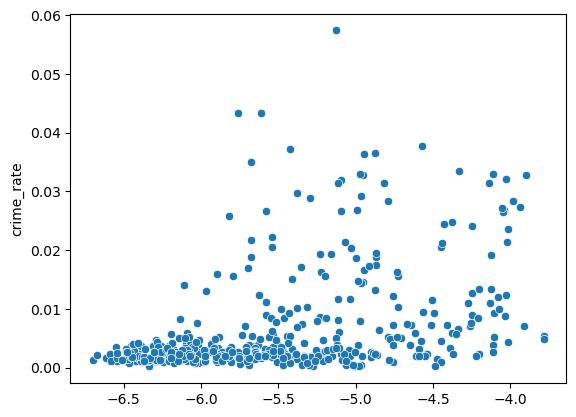

In [188]:
sns.scatterplot(data=analysis_df, y="crime_rate", x = y_preds)

In [227]:
rf.fit(X,y)
pd.DataFrame(zip(X.columns, rf.feature_importances_)).sort_values(1)

,0,1
0,const,0.000000
4,ptg_share,0.039052
5,inc_5k_plus_share,0.041545
9,house_type3,0.046522
8,disab_share,0.051277
6,ed_prim_share,0.082058
3,st_share,0.087750
7,land_own_share,0.111893
2,sc_share,0.180547
1,tot_p,0.359356


In [189]:
ls = Lasso(alpha=0.05)

cross_val_score(ls, X, y, scoring="neg_mean_absolute_error")

array([-0.78697806, -0.7404129 , -1.01897826, -0.49747881, -0.75312477])

In [190]:
ls.fit(X, y)
pd.DataFrame(zip(X.columns, ls.coef_)).sort_values(by=1)

,0,1
1,tot_p,-0.438386
3,st_share,-0.190096
7,land_own_share,-0.101251
6,ed_prim_share,-0.068859
0,const,0.000000
4,ptg_share,-0.000000
5,inc_5k_plus_share,-0.000000
8,disab_share,-0.000000
9,house_type3,0.009963
2,sc_share,0.199565


In [191]:
y_preds = cross_val_predict(ls, X, y)

<Axes: ylabel='crime_rate'>

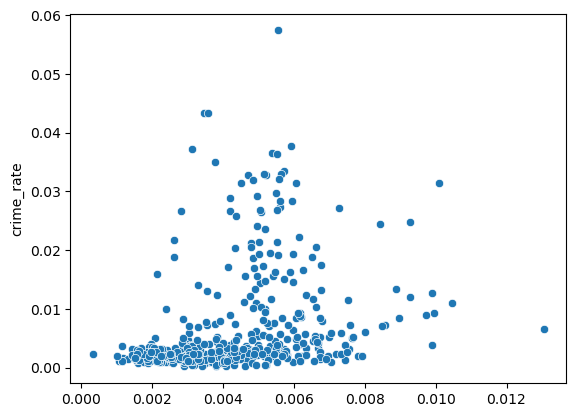

In [193]:
sns.scatterplot(data=analysis_df, y="crime_rate", x = np.exp(y_preds))

### Other IPC Analysis

In [217]:
X = sm.add_constant(analysis_df[features].apply(norm, axis=0))
y = np.log(analysis_df["other_ipc_rate"])

In [195]:

ols = sm.OLS(y, X)

results = ols.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         other_ipc_rate   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     24.68
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           3.55e-34
Time:                        21:27:09   Log-Likelihood:                -643.10
No. Observations:                 444   AIC:                             1306.
Df Residuals:                     434   BIC:                             1347.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.6813      0.049   -135.145      0.000      -6.778      -6.584
tot_p                -0.6416      0.054    -11.802      0.000      -0.748      -0.535
sc_share              0.2371      0.063      3.751      0.000       0.113       0.361
st_share             -0.3780      0.071     -5.333      0.000      -0.517      -0.239
ptg_share            -0.0512      0.053     -0.963      0.336      -0.156       0.053
inc_5k_plus_share    -0.0806      0.065     -1.237      0.217      -0.209       0.047
ed_prim_share        -0.1451      0.058     -2.517      0.012      -0.258      -0.032
land_own_share       -0.1428      0.053     -2.701      0.007      -0.247      -0.039
disab_share           0.0117      0.054      0.216      0.829      -0.095       0.119
house_type3           0.1025      0.053      1.940      0.053      -0.001       0.206
==============================================================================
Omnibus:                        5.186   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                6.892
Skew:                          -0.036   Prob(JB):                       0.0319
Kurtosis:                       3.606   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
rf = RandomForestRegressor(n_estimators = 300)
cross_val_score(rf, X, y, scoring="neg_mean_absolute_error")

array([-0.72904987, -0.87999239, -1.30715014, -1.1069321 , -1.12376217])

In [219]:
y_preds = cross_val_predict(rf, X, y)

<Axes: ylabel='other_ipc_rate'>

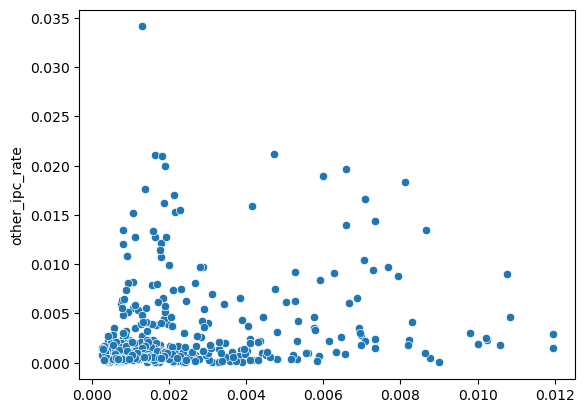

In [220]:
sns.scatterplot(data=analysis_df, y="other_ipc_rate", x = np.exp(y_preds))

In [223]:
rf.fit(X,y)
pd.DataFrame(zip(X.columns, rf.feature_importances_)).sort_values(1)

,0,1
0,const,0.000000
4,ptg_share,0.038716
8,disab_share,0.052791
9,house_type3,0.058785
5,inc_5k_plus_share,0.066347
6,ed_prim_share,0.070755
7,land_own_share,0.093021
3,st_share,0.101090
2,sc_share,0.180570
1,tot_p,0.337926


In [200]:
ls = Lasso(alpha=0.1)

cross_val_score(ls, X, y, scoring="neg_mean_absolute_error")

array([-0.77488174, -0.85147384, -1.24644168, -0.79656473, -1.12662917])

In [201]:
y_preds = cross_val_predict(ls, X, y)

<Axes: ylabel='other_ipc_rate'>

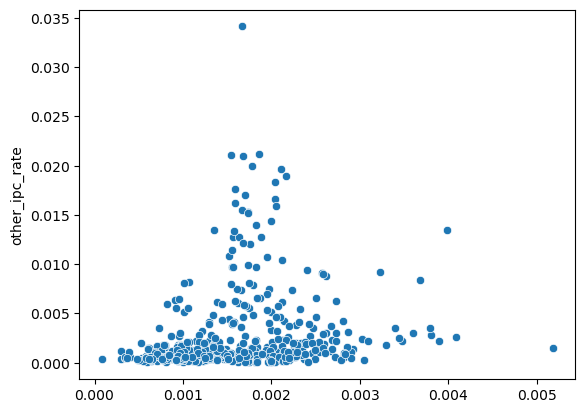

In [202]:
sns.scatterplot(data=analysis_df, y="other_ipc_rate", x = np.exp(y_preds))

In [203]:
ls.fit(X, y)
pd.DataFrame(zip(X.columns, ls.coef_)).sort_values(by=1)

,0,1
1,tot_p,-0.440154
3,st_share,-0.222824
6,ed_prim_share,-0.034508
0,const,0.000000
4,ptg_share,-0.000000
5,inc_5k_plus_share,-0.000000
7,land_own_share,-0.000000
8,disab_share,0.000000
9,house_type3,0.000000
2,sc_share,0.206977


### Srs vs non srs crimes

In [204]:
X = sm.add_constant(analysis_df[features].apply(norm, axis=0))
y = np.exp(analysis_df["other_crime_proportion"])

In [205]:

ols = sm.OLS(y, X)

results = ols.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     other_crime_proportion   R-squared:                       0.122
Model:                                OLS   Adj. R-squared:                  0.104
Method:                     Least Squares   F-statistic:                     6.696
Date:                    Tue, 19 Mar 2024   Prob (F-statistic):           5.34e-09
Time:                            21:28:25   Log-Likelihood:                 40.771
No. Observations:                     444   AIC:                            -61.54
Df Residuals:                         434   BIC:                            -20.58
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.4881      0.011    140.440      0.000       1.467       1.509
tot_p                -0.0577      0.012     -4.955      0.000      -0.081      -0.035
sc_share              0.0119      0.014      0.878      0.380      -0.015       0.039
st_share             -0.0554      0.015     -3.643      0.000      -0.085      -0.025
ptg_share            -0.0041      0.011     -0.361      0.718      -0.027       0.018
inc_5k_plus_share    -0.0451      0.014     -3.228      0.001      -0.073      -0.018
ed_prim_share         0.0029      0.012      0.233      0.816      -0.021       0.027
land_own_share        0.0174      0.011      1.539      0.124      -0.005       0.040
disab_share           0.0180      0.012      1.543      0.123      -0.005       0.041
house_type3           0.0081      0.011      0.717      0.474      -0.014       0.030
==============================================================================
Omnibus:                       30.855   Durbin-Watson:                   1.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.838
Skew:                           0.695   Prob(JB):                     1.65e-08
Kurtosis:                       3.080   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
ls = Lasso(alpha=0.025)

cross_val_score(ls, X, y, scoring="neg_mean_absolute_error")

array([-0.19831373, -0.15760513, -0.19929488, -0.25962498, -0.25353203])

In [214]:
y_preds = cross_val_predict(ls, X, y)

<Axes: ylabel='other_crime_proportion'>

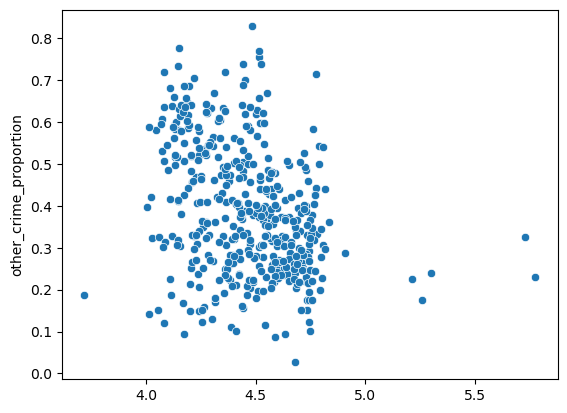

In [215]:
sns.scatterplot(data=analysis_df, y="other_crime_proportion", x = np.exp(y_preds))

In [216]:
ls.fit(X, y)
pd.DataFrame(zip(X.columns, ls.coef_)).sort_values(by=1)

,0,1
1,tot_p,-0.017815
3,st_share,-0.013131
5,inc_5k_plus_share,-0.000002
0,const,0.000000
4,ptg_share,-0.000000
6,ed_prim_share,-0.000000
9,house_type3,0.000000
2,sc_share,0.002554
7,land_own_share,0.002759
8,disab_share,0.005966
